

# EDAノートブック 目次案

```markdown
# CMI Detect Behavior with Sensor Data - EDA

## 1. はじめに
- 目的とデータ概要
- フォルダ構成とファイル説明

## 2. データ読み込みと基本確認
- train.csv, test.csv, demographicsファイルの読み込み
- 基本情報（行数・列数・欠損値）

## 3. ラベル分布の確認（trainデータ）
- BFRB / Non-BFRBの割合
- ジェスチャー別分布

## 4. 被験者属性の確認
- demographicsデータの概要
- 被験者ごとのサンプル数分布
- 年齢・性別など主要属性の分布

## 5. センサーデータの時系列可視化
- 代表的なシーケンスの加速度波形
- 熱センサ・距離センサ波形の可視化

## 6. シーケンス長・時系列特性
- シーケンス長の分布
- 被験者ごとの平均シーケンス長

## 7. センサーデータの相関・特徴量候補
- センサーチャンネル間の相関分析
- 重要そうな特徴量の候補抽出

## 8. 被験者・姿勢・動作フェーズ分析
- 被験者間のバラツキ
- 姿勢（orientation）分布
- 動作フェーズ（phase）分布

## 9. 欠損値・異常値の検出と対策
- 欠損パターンの解析
- 異常値処理案

## 10. まとめと今後の方向性
- 主な気づきまとめ
- 次の開発ステップ提案
```




# 1. はじめに


このノートブックでは、CMIコンペティションのセンサーデータを用いた行動検知問題について
データの理解と初期探索を行います。

### 目的
- データ構造の理解
- ラベル分布や被験者属性の確認
- センサーデータの特徴把握
- 欠損や異常値の検出

### データ概要
- トレーニングデータ、テストデータ、被験者属性データの3種類が提供されている
- センサーは加速度（acc）、角速度（gyr）、熱（thm）、距離（tof）など多種類
- 解析対象は体中心型反復行動（BFRB）の検出

# 2. データ読み込みと基本確認




In [15]:
import pandas as pd

# データ読み込み
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
train_demo = pd.read_csv("../data/train_demographics.csv")
test_demo = pd.read_csv("../data/test_demographics.csv")

# 基本情報表示関数
def show_basic_info(df, name):
    print(f"=== {name} ===")
    print(f"Shape: {df.shape}")
    print("Columns:", len(df.columns))
    print(df.dtypes.value_counts())
    print("Missing values per column (top 10):")
    print(df.isna().sum().sort_values(ascending=False).head(10))
    print(df.head(3))
    print()

# train/testデータ基本情報
show_basic_info(train_df, "train.csv")
show_basic_info(test_df, "test.csv")

# demographics基本情報
show_basic_info(train_demo, "train_demographics.csv")
show_basic_info(test_demo, "test_demographics.csv")

# demographicsデータ件数の特徴的な違いをコメント
print(f"被験者数（train_demo）: {train_demo['subject'].nunique()}")
print(f"被験者数（test_demo）: {test_demo['subject'].nunique()}")

if test_demo.shape[0] < 10:
    print("※test_demographics.csvの件数が少ないため、補足情報として限定的かもしれません。")


=== train.csv ===
Shape: (574945, 341)
Columns: 341
float64    332
object       8
int64        1
Name: count, dtype: int64
Missing values per column (top 10):
thm_5        33286
tof_5_v17    30142
tof_5_v16    30142
tof_5_v15    30142
tof_5_v14    30142
tof_5_v60    30142
tof_5_v62    30142
tof_5_v11    30142
tof_5_v10    30142
tof_5_v9     30142
dtype: int64
              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000007_000000        Target  SEQ_000007                 0  SUBJ_059520   
1  SEQ_000007_000001        Target  SEQ_000007                 1  SUBJ_059520   
2  SEQ_000007_000002        Target  SEQ_000007                 2  SUBJ_059520   

                       orientation                                   behavior  \
0  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
1  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
2  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target l


# 3. ラベル分布の確認（trainデータ）

/tmp/ipykernel_685334/1457798042.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="sequence_type", data=seq_info, palette=["#FF6F61", "#4CAF50"])


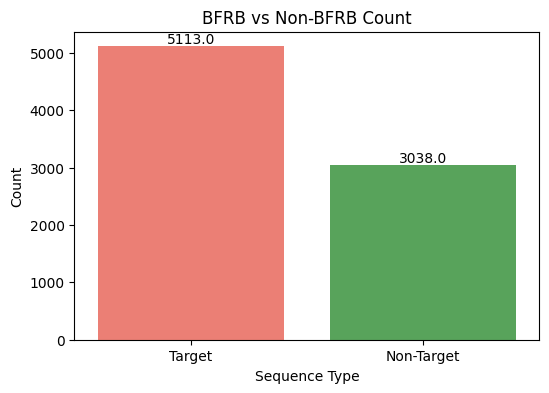

/tmp/ipykernel_685334/1457798042.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y="gesture", data=seq_info[seq_info['gesture'].isin(top_gestures)],


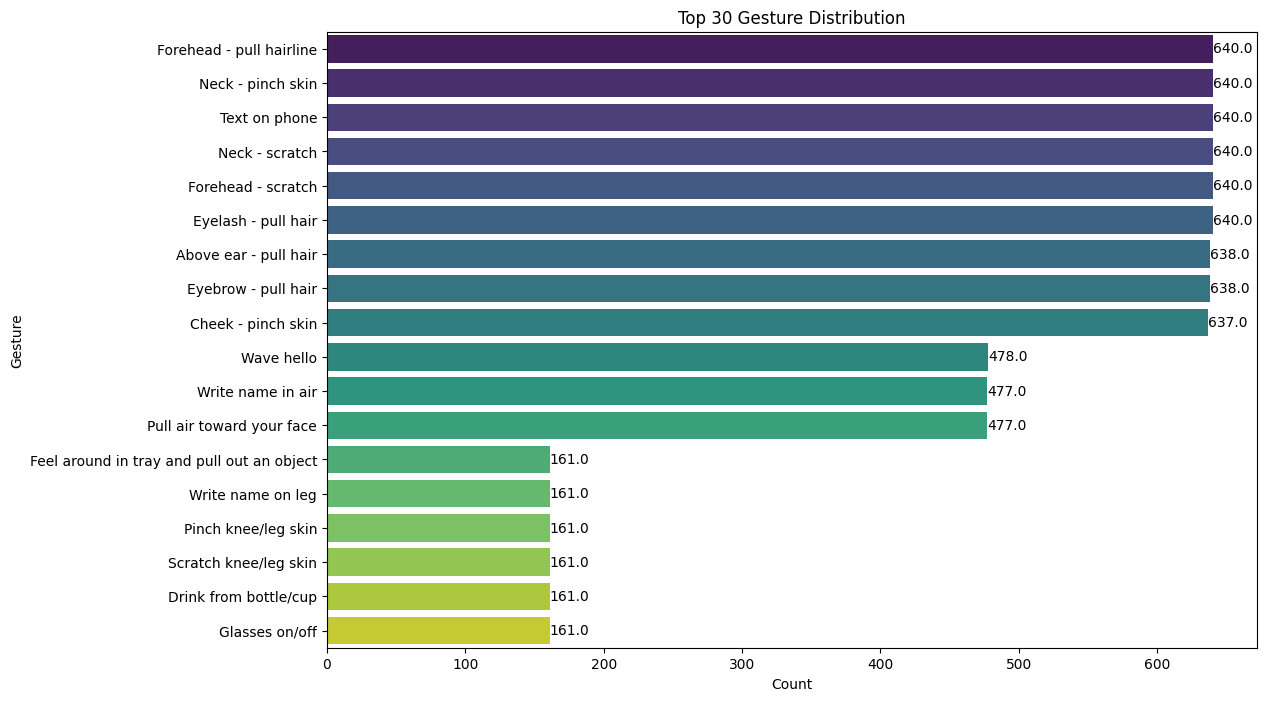

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

seq_info = train_df.drop_duplicates(subset="sequence_id")

# BFRB vs Non-BFRB Count
plt.figure(figsize=(6,4))
ax = sns.countplot(x="sequence_type", data=seq_info, palette=["#FF6F61", "#4CAF50"])
plt.title("BFRB vs Non-BFRB Count")
plt.xlabel("Sequence Type")
plt.ylabel("Count")

# 棒の上に数値表示
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')
plt.show()

# ジェスチャー分布（上位30件）
top_gestures = seq_info['gesture'].value_counts().nlargest(30).index
plt.figure(figsize=(12,8))
ax = sns.countplot(y="gesture", data=seq_info[seq_info['gesture'].isin(top_gestures)],
                   order=top_gestures, palette="viridis")
plt.title("Top 30 Gesture Distribution")
plt.xlabel("Count")
plt.ylabel("Gesture")

# 棒の上に数値表示
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width}', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center')
plt.show()


# 4. 被験者属性の確認


=== Train Demographics info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject               81 non-null     object 
 1   adult_child           81 non-null     int64  
 2   age                   81 non-null     int64  
 3   sex                   81 non-null     int64  
 4   handedness            81 non-null     int64  
 5   height_cm             81 non-null     float64
 6   shoulder_to_wrist_cm  81 non-null     int64  
 7   elbow_to_wrist_cm     81 non-null     float64
dtypes: float64(2), int64(5), object(1)
memory usage: 5.2+ KB
None

Missing value ratio per column:
Series([], dtype: float64)

Train Demographics describe (all columns):
                     count unique          top freq        mean        std  \
subject                 81     81  SUBJ_000206    1         NaN        NaN   
adult_child           81.0   

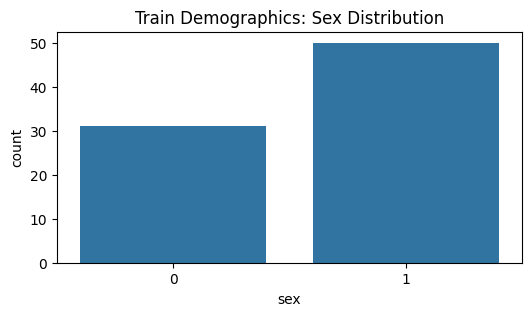

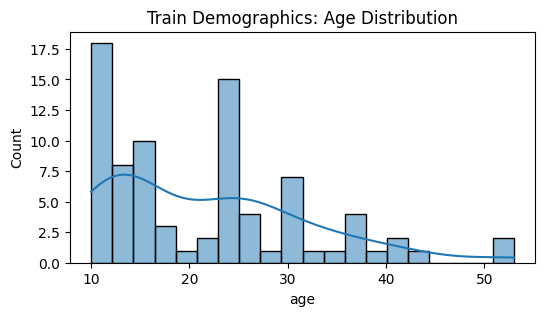

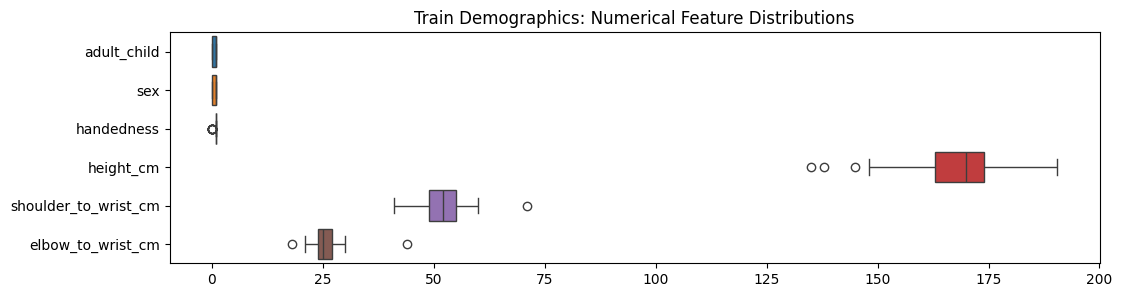

=== Test Demographics info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject               2 non-null      object 
 1   adult_child           2 non-null      int64  
 2   age                   2 non-null      int64  
 3   sex                   2 non-null      int64  
 4   handedness            2 non-null      int64  
 5   height_cm             2 non-null      float64
 6   shoulder_to_wrist_cm  2 non-null      int64  
 7   elbow_to_wrist_cm     2 non-null      float64
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
None

Missing value ratio per column:
Series([], dtype: float64)

Test Demographics describe (all columns):
                     count unique          top freq   mean       std    min  \
subject                  2      2  SUBJ_016452    1    NaN       NaN    NaN   
adult_child            2.0

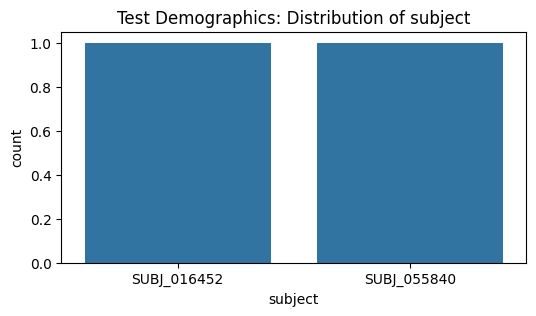

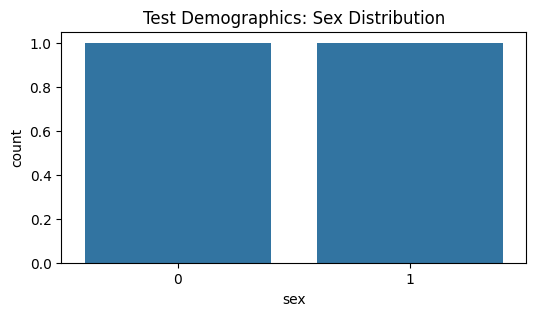

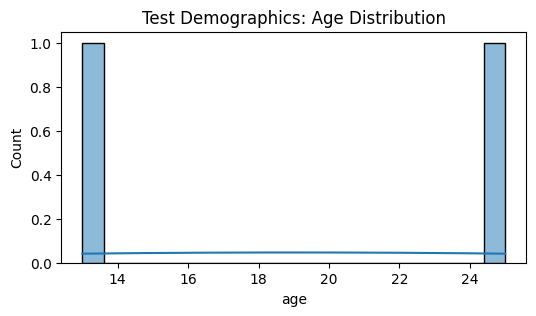

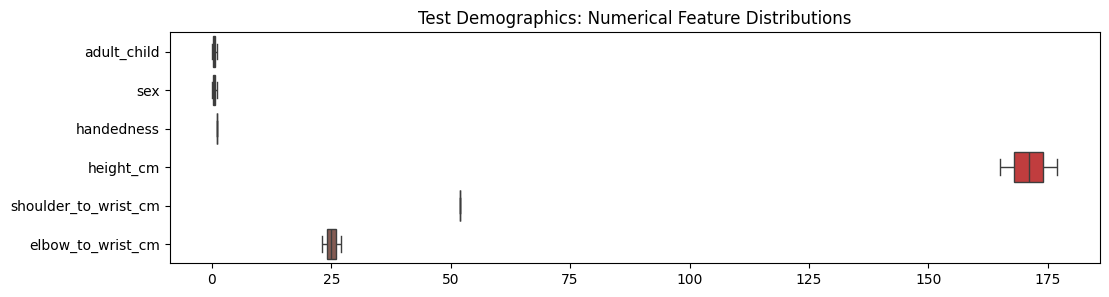

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def explore_demographics(df, dataset_name="Dataset"):
    print(f"=== {dataset_name} info ===")
    print(df.info())
    
    # 欠損値割合
    missing_ratio = df.isna().mean()
    print("\nMissing value ratio per column:")
    print(missing_ratio[missing_ratio > 0].sort_values(ascending=False))
    
    print(f"\n{dataset_name} describe (all columns):")
    print(df.describe(include='all').T)
    
    # カテゴリカル変数（object型かつユニーク数3以下）を抽出
    cat_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() <= 3]
    
    # 代表的なカテゴリ変数の分布プロット
    for col in cat_cols:
        plt.figure(figsize=(6,3))
        sns.countplot(x=col, data=df)
        plt.title(f"{dataset_name}: Distribution of {col}")
        plt.show()
    
    # 性別・年齢があれば個別にプロット
    if 'sex' in df.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(x='sex', data=df)
        plt.title(f"{dataset_name}: Sex Distribution")
        plt.show()
    
    if 'age' in df.columns:
        plt.figure(figsize=(6,3))
        sns.histplot(df['age'].dropna(), bins=20, kde=True)
        plt.title(f"{dataset_name}: Age Distribution")
        plt.show()
        
    # 数値型列を抽出し箱ひげ図で分布確認
    num_cols = df.select_dtypes(include=['int64','float64']).columns
    num_cols = [col for col in num_cols if col not in ['age']]  # ageは既に描画済み
    
    if len(num_cols) > 0:
        plt.figure(figsize=(12, 0.5 * len(num_cols)))
        sns.boxplot(data=df[num_cols], orient='h')
        plt.title(f"{dataset_name}: Numerical Feature Distributions")
        plt.show()

# 実行例
explore_demographics(train_demo, "Train Demographics")
explore_demographics(test_demo, "Test Demographics")



# 5. センサーデータの時系列可視化


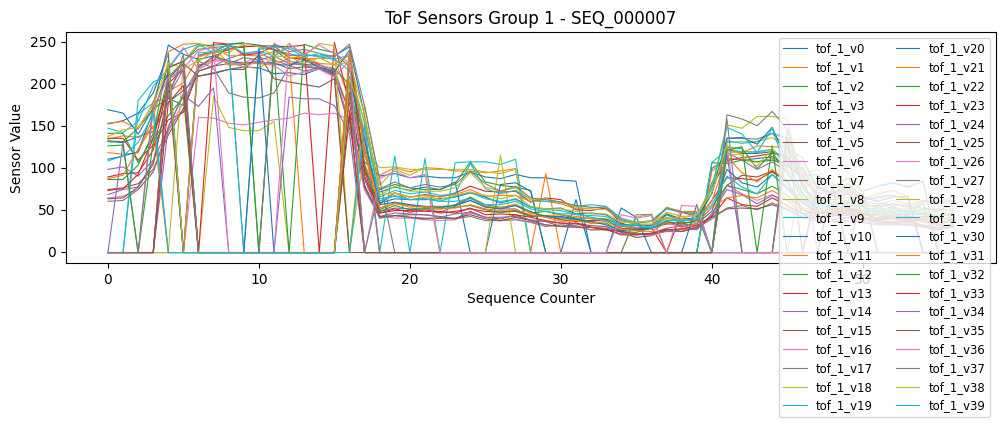

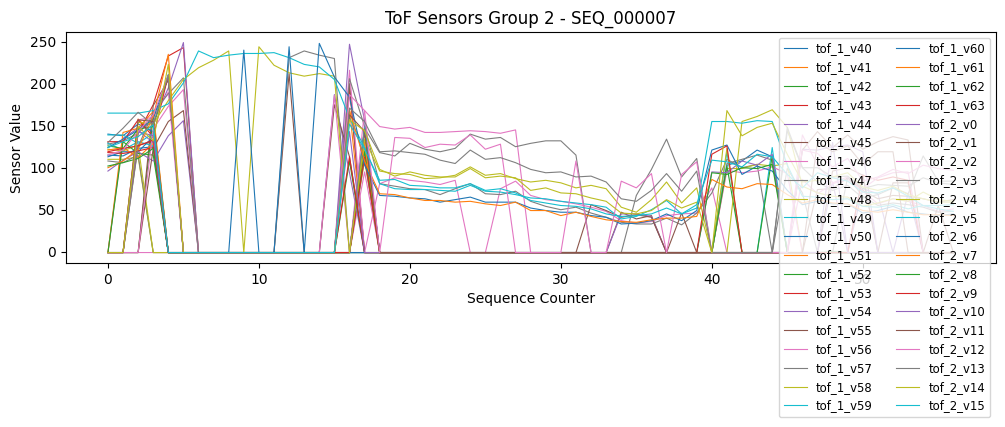

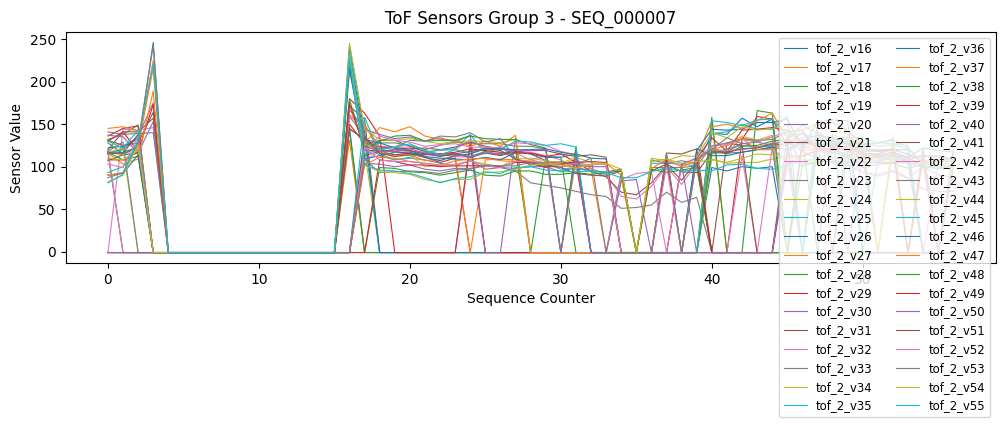

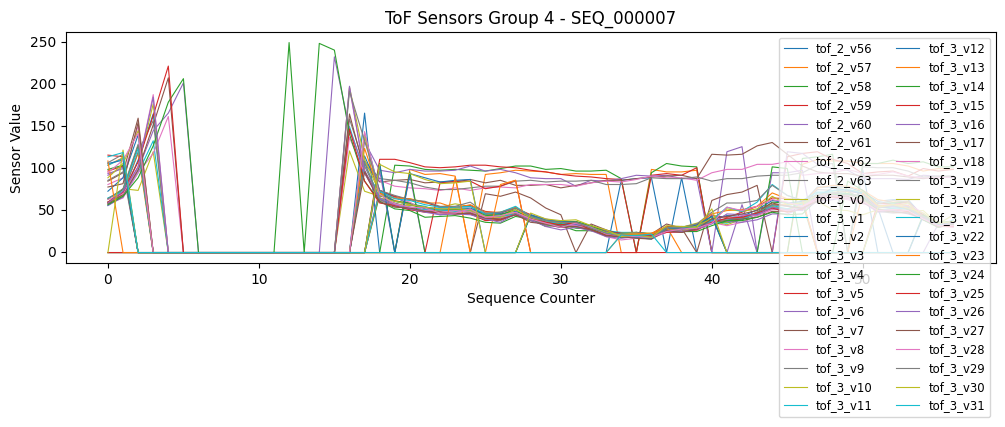

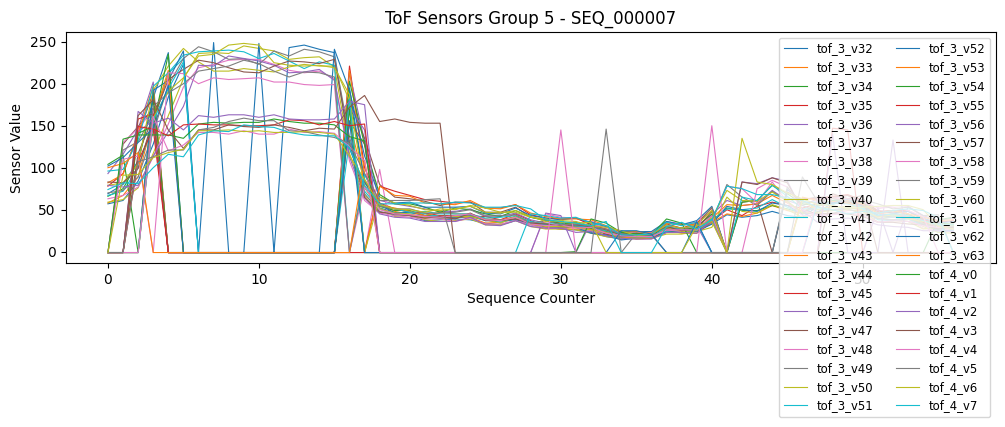

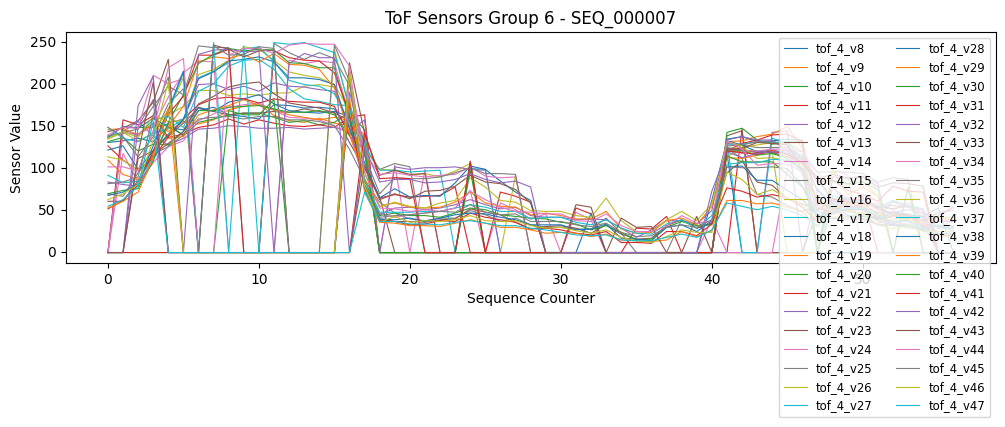

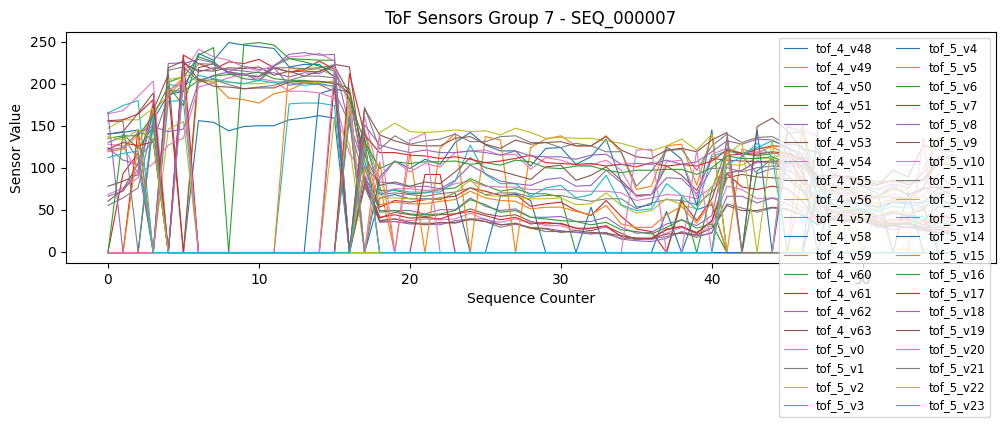

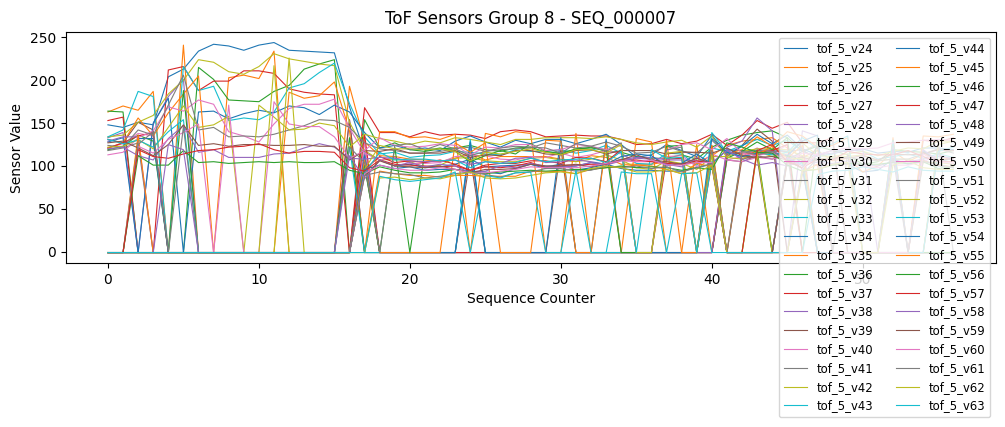

In [19]:
import matplotlib.pyplot as plt
import math

# シーケンスIDの指定（例）
seq_id = train_df['sequence_id'].iloc[0]
sample = train_df[train_df['sequence_id'] == seq_id]

# ToFセンサー列抽出
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

# 分割数（グラフの枚数）
num_plots = 8
channels_per_plot = math.ceil(len(tof_cols) / num_plots)

for i in range(num_plots):
    plt.figure(figsize=(12,3))
    subset = tof_cols[i*channels_per_plot:(i+1)*channels_per_plot]
    for col in subset:
        plt.plot(sample['sequence_counter'], sample[col], label=col, linewidth=0.8)
    plt.title(f"ToF Sensors Group {i+1} - {seq_id}")
    plt.xlabel("Sequence Counter")
    plt.ylabel("Sensor Value")
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.show()



# 6. シーケンス長・時系列特性

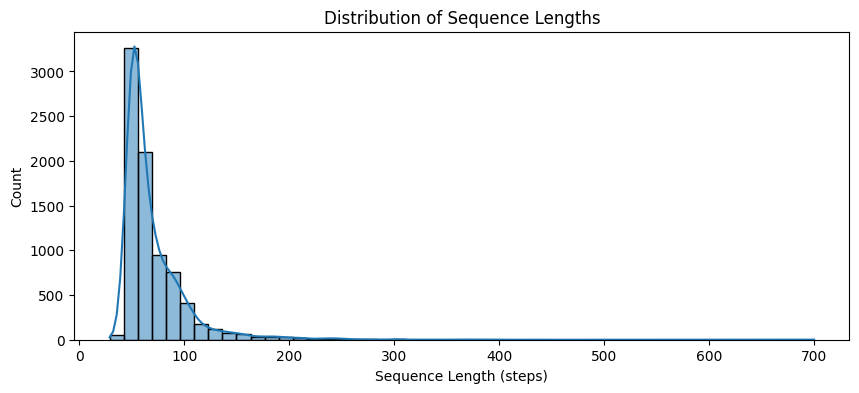

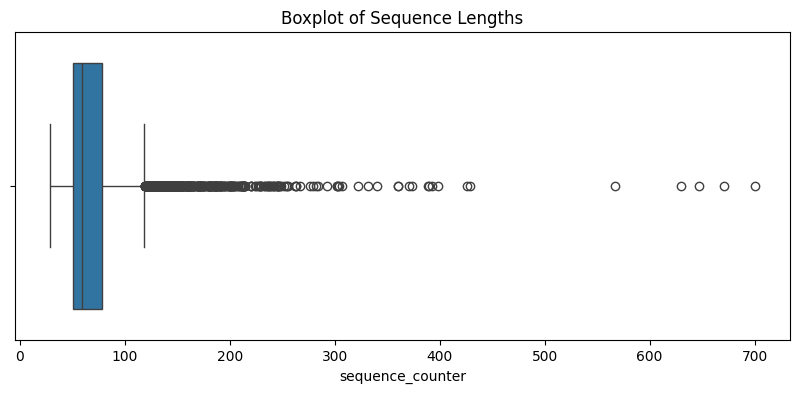

In [11]:

# シーケンス長（時間ステップ数）を計算
seq_lengths = train_df.groupby('sequence_id')['sequence_counter'].max() + 1

plt.figure(figsize=(10,4))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length (steps)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x=seq_lengths)
plt.title("Boxplot of Sequence Lengths")
plt.show()



# 7. センサーデータの相関・特徴量


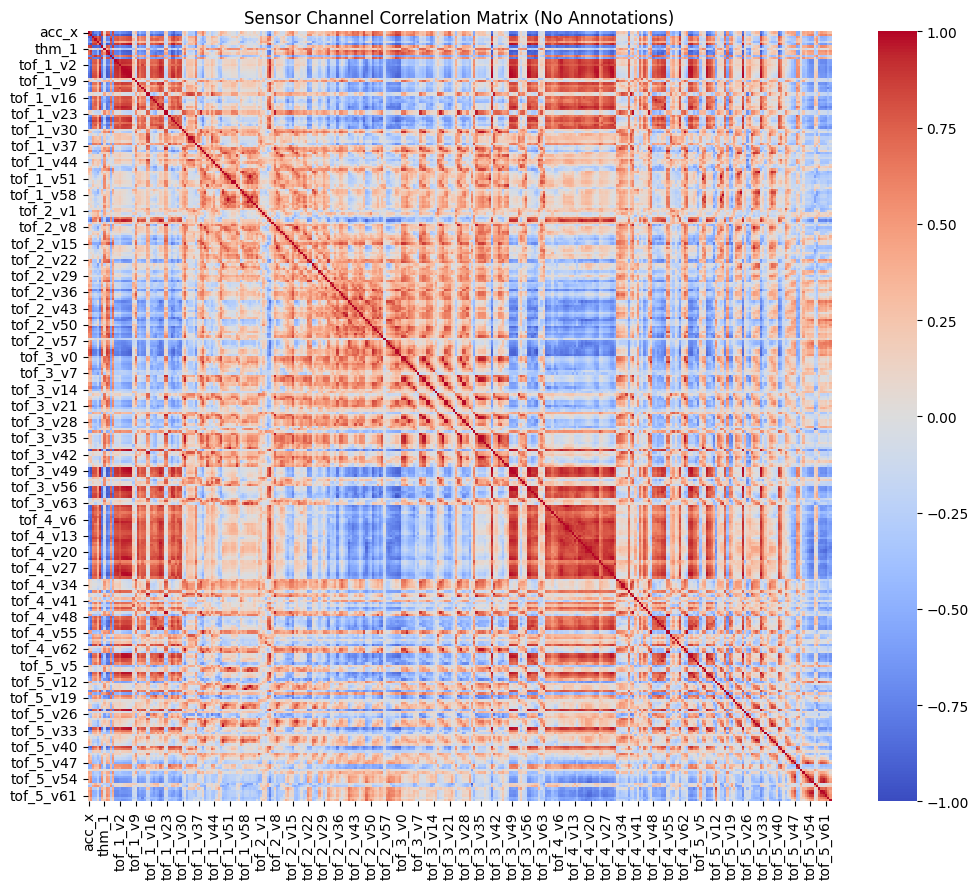

Strong correlations (|corr| >= 0.8):
        Sensor1    Sensor2  Correlation
1603  tof_1_v61  tof_1_v59     0.999808
1587  tof_1_v59  tof_1_v61     0.999808
5392  tof_5_v31  tof_1_v48     0.999794
1540  tof_1_v48  tof_5_v31     0.999794
5489  tof_5_v37  tof_5_v30     0.999238
...         ...        ...          ...
30        acc_y   tof_1_v6    -0.968621
20        acc_y      rot_y    -0.972078
147       rot_y      acc_y    -0.972078
840    tof_1_v7      acc_y    -0.978068
31        acc_y   tof_1_v7    -0.978068

[5600 rows x 3 columns]


In [25]:
thm_cols = [col for col in train_df.columns if col.startswith('thm_')]
tof_cols = [col for col in train_df.columns if col.startswith('tof_')]

# 角速度は 'rot_' 系列を使用
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z'] + thm_cols + tof_cols

sample_corr = train_df[train_df['sequence_id'] == seq_id][sensor_cols]

corr_matrix = sample_corr.corr()

# plt.figure(figsize=(12,10))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title("Sensor Channel Correlation Matrix")
# plt.show()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Sensor Channel Correlation Matrix (No Annotations)")
plt.show()
import numpy as np

strong_corr = corr_matrix[(corr_matrix.abs() >= 0.8) & (corr_matrix.abs() < 1.0)].stack().reset_index()
strong_corr.columns = ['Sensor1', 'Sensor2', 'Correlation']
strong_corr = strong_corr.sort_values(by='Correlation', ascending=False)

print("Strong correlations (|corr| >= 0.8):")
print(strong_corr)


In [20]:
print(train_df.columns.tolist())


['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1_v51', 'tof_1_v52', 'tof_1_v53', 'tof_1_v54', 'tof_1_v55', 'tof_1_v56', 'tof_1_v57', 'tof_1_v58', 'tof_1_v59', '



# 8. 被験者・姿勢・動作フェーズ分析



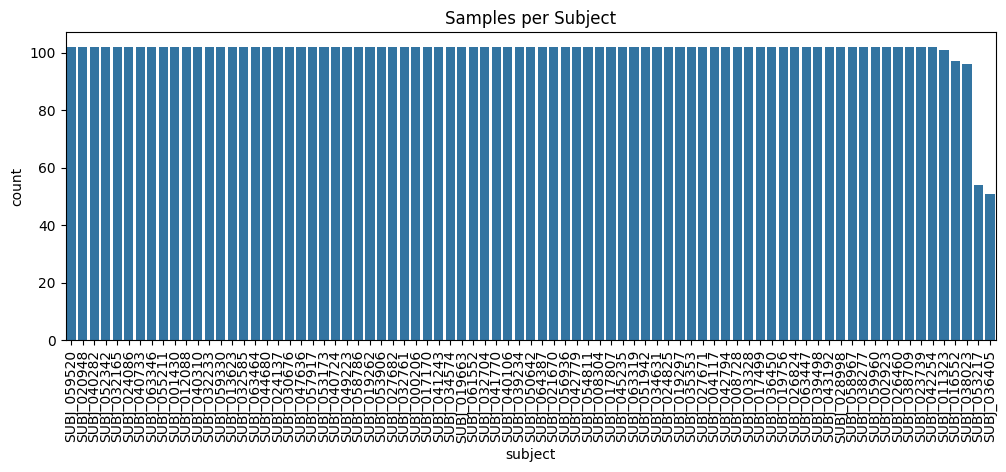

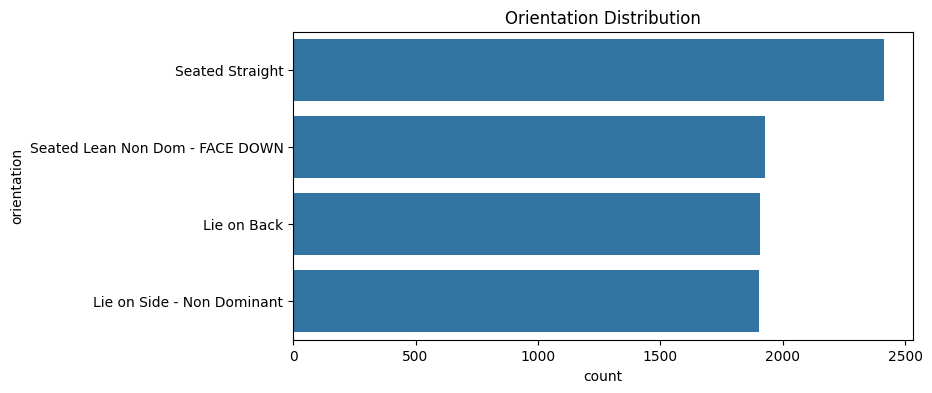

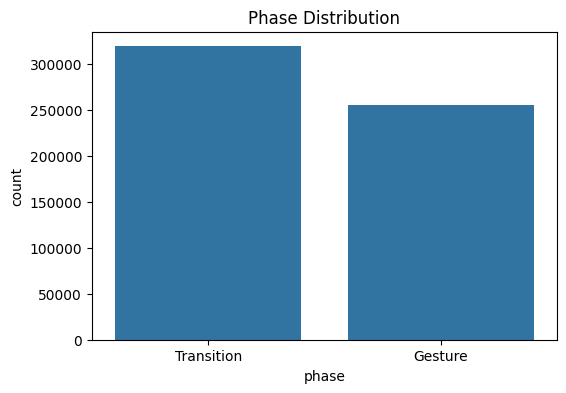

In [27]:

# 被験者ごとのサンプル数
seq_info = train_df.drop_duplicates(subset='sequence_id')
plt.figure(figsize=(12,4))
sns.countplot(x='subject', data=seq_info, order=seq_info['subject'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Samples per Subject")
plt.show()

# 姿勢（orientation）分布
plt.figure(figsize=(8,4))
sns.countplot(y='orientation', data=seq_info, order=seq_info['orientation'].value_counts().index)
plt.title("Orientation Distribution")
plt.show()

# 動作フェーズ（phase）分布
plt.figure(figsize=(6,4))
sns.countplot(x='phase', data=train_df)
plt.title("Phase Distribution")
plt.show()

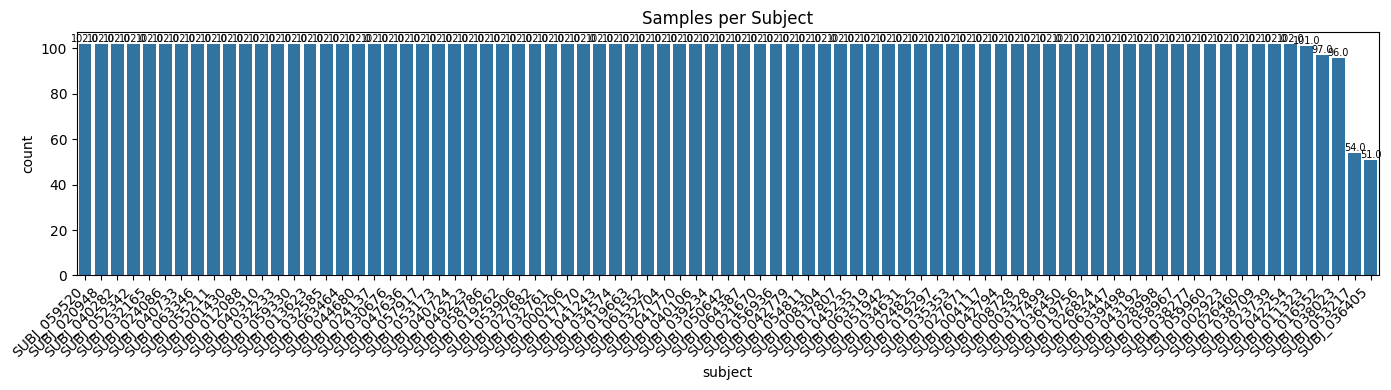

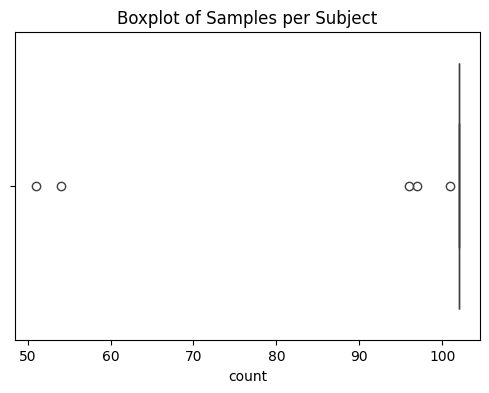

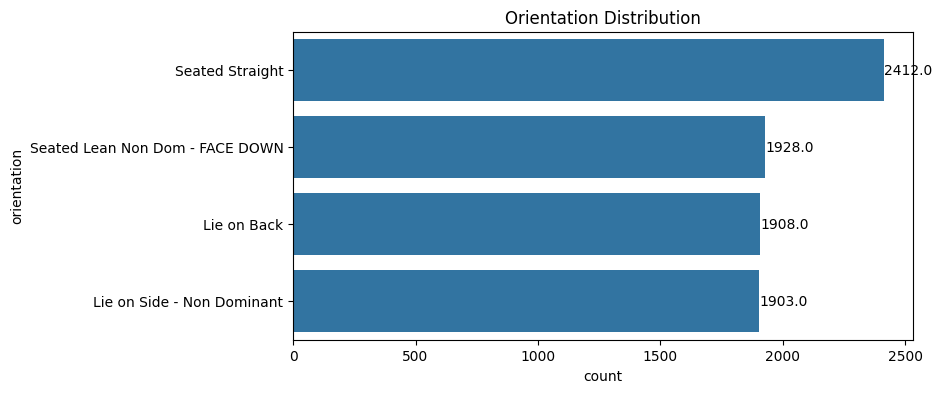

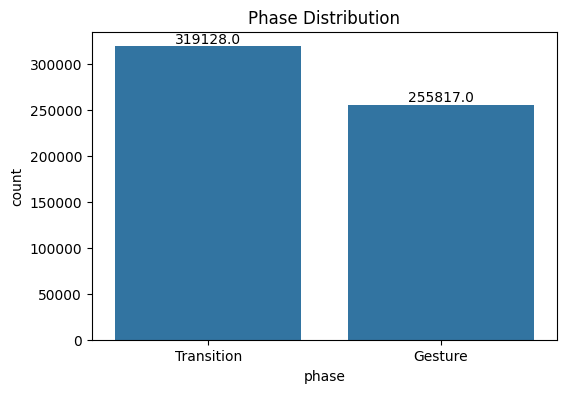

In [28]:
seq_info = train_df.drop_duplicates(subset='sequence_id')

# 被験者ごとのサンプル数（棒グラフ）
plt.figure(figsize=(14,4))
ax = sns.countplot(x='subject', data=seq_info, order=seq_info['subject'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Samples per Subject")
plt.tight_layout()

# 棒の上に数値表示
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=7)
plt.show()

# 被験者ごとのサンプル数（箱ひげ図）
plt.figure(figsize=(6,4))
sns.boxplot(x=seq_info['subject'].value_counts())
plt.title("Boxplot of Samples per Subject")
plt.show()

# 姿勢（orientation）分布
plt.figure(figsize=(8,4))
ax = sns.countplot(y='orientation', data=seq_info, order=seq_info['orientation'].value_counts().index)
plt.title("Orientation Distribution")

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width}', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10)
plt.show()

# 動作フェーズ（phase）分布
plt.figure(figsize=(6,4))
ax = sns.countplot(x='phase', data=train_df)
plt.title("Phase Distribution")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)
plt.show()



# 9. 欠損値・異常値の検出と対策

In [23]:



# 欠損値確認
missing_counts = train_df.isna().sum()
print("欠損値カウント（train.csv）:")
print(missing_counts[missing_counts > 0])

# -1などの異常値（例：距離センサーの-1が多い）
for col in tof_cols:
    print(f"{col}の-1の数: {(train_df[col] == -1).sum()}")


欠損値カウント（train.csv）:
rot_w         3692
rot_x         3692
rot_y         3692
rot_z         3692
thm_1         6987
             ...  
tof_5_v59    30142
tof_5_v60    30142
tof_5_v61    30142
tof_5_v62    30142
tof_5_v63    30142
Length: 329, dtype: int64
tof_1_v0の-1の数: 289963
tof_1_v1の-1の数: 294126
tof_1_v2の-1の数: 292777
tof_1_v3の-1の数: 288300
tof_1_v4の-1の数: 282406
tof_1_v5の-1の数: 281431
tof_1_v6の-1の数: 281894
tof_1_v7の-1の数: 277707
tof_1_v8の-1の数: 312469
tof_1_v9の-1の数: 311875
tof_1_v10の-1の数: 311232
tof_1_v11の-1の数: 305664
tof_1_v12の-1の数: 298552
tof_1_v13の-1の数: 298727
tof_1_v14の-1の数: 297658
tof_1_v15の-1の数: 299392
tof_1_v16の-1の数: 330057
tof_1_v17の-1の数: 326306
tof_1_v18の-1の数: 319637
tof_1_v19の-1の数: 320780
tof_1_v20の-1の数: 316071
tof_1_v21の-1の数: 310747
tof_1_v22の-1の数: 312900
tof_1_v23の-1の数: 317062
tof_1_v24の-1の数: 343736
tof_1_v25の-1の数: 333417
tof_1_v26の-1の数: 338906
tof_1_v27の-1の数: 340880
tof_1_v28の-1の数: 331698
tof_1_v29の-1の数: 323144
tof_1_v30の-1の数: 319541
tof_1_v31の-1の数: 328106
tof_1_v32の-1の数: 351

欠損率上位20列:
thm_5        0.057894
tof_5_v45    0.052426
tof_5_v46    0.052426
tof_5_v47    0.052426
tof_5_v48    0.052426
tof_5_v49    0.052426
tof_5_v50    0.052426
tof_5_v51    0.052426
tof_5_v10    0.052426
tof_5_v53    0.052426
tof_5_v54    0.052426
tof_5_v55    0.052426
tof_5_v56    0.052426
tof_5_v57    0.052426
tof_5_v58    0.052426
tof_5_v59    0.052426
tof_5_v52    0.052426
tof_5_v11    0.052426
tof_5_v12    0.052426
tof_5_v13    0.052426
dtype: float64


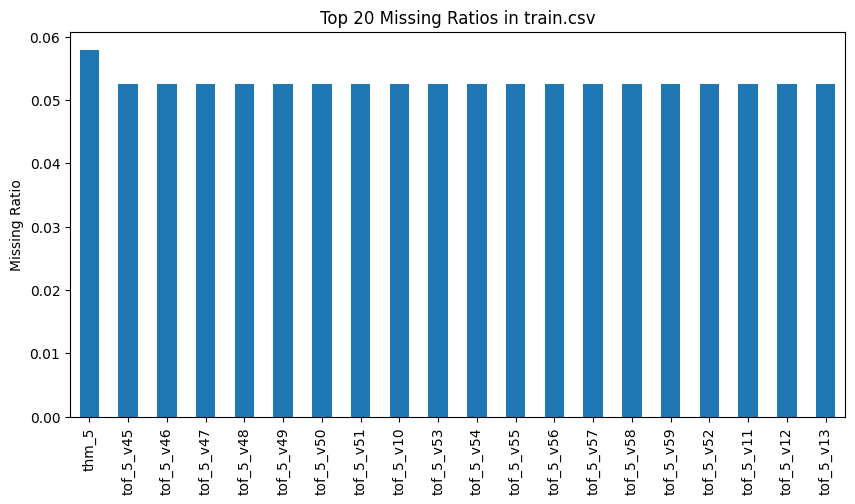

-1率上位20 ToF列:
tof_3_v15    0.720316
tof_3_v23    0.704714
tof_3_v6     0.694166
tof_3_v7     0.694007
tof_3_v14    0.693505
tof_5_v55    0.691478
tof_3_v31    0.687165
tof_5_v47    0.686718
tof_3_v22    0.680195
tof_5_v63    0.679917
tof_5_v39    0.678747
tof_2_v48    0.675355
tof_3_v39    0.672539
tof_3_v5     0.671061
tof_2_v40    0.669554
tof_2_v56    0.667723
tof_3_v13    0.664561
tof_5_v54    0.664437
tof_2_v57    0.663634
tof_2_v49    0.661837
dtype: float64


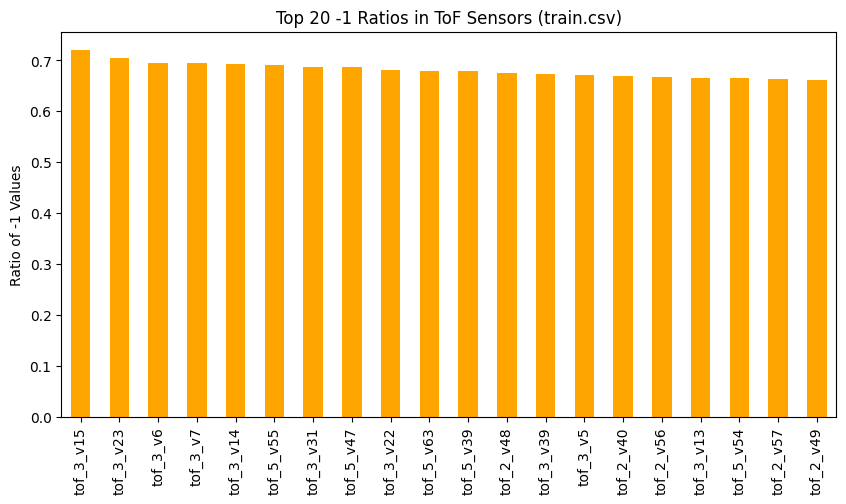

In [29]:
import matplotlib.pyplot as plt

# 欠損値割合を計算
missing_ratio = train_df.isna().mean()

# -1の割合を計算（ToF列のみ）
neg_one_ratio = {}
for col in tof_cols:
    neg_one_ratio[col] = (train_df[col] == -1).mean()
neg_one_ratio = pd.Series(neg_one_ratio)

# 欠損率上位20列表示
top_missing = missing_ratio[missing_ratio > 0].sort_values(ascending=False).head(20)
print("欠損率上位20列:")
print(top_missing)

plt.figure(figsize=(10,5))
top_missing.plot(kind='bar')
plt.ylabel("Missing Ratio")
plt.title("Top 20 Missing Ratios in train.csv")
plt.show()

# -1率上位20列表示
top_neg_one = neg_one_ratio[neg_one_ratio > 0].sort_values(ascending=False).head(20)
print("-1率上位20 ToF列:")
print(top_neg_one)

plt.figure(figsize=(10,5))
top_neg_one.plot(kind='bar', color='orange')
plt.ylabel("Ratio of -1 Values")
plt.title("Top 20 -1 Ratios in ToF Sensors (train.csv)")
plt.show()


In [24]:

# 10. まとめと今後の方向性

- BFRBと非BFRBのサンプル数に偏りはあるが、被験者ごとのサンプル数は均一
- センサーデータは多チャネルで、多様な特徴が観察される
- シーケンス長の幅が広いため、時系列長さの扱いが課題
- 姿勢や動作フェーズなどの補助情報を特徴量に活用可能
- 欠損や異常値の処理方針を検討する必要あり

次のステップ：
- 特徴量設計とモデル構築
- 被験者分割のクロスバリデーション設計
- 時系列データの前処理（パディング等）


SyntaxError: invalid character '、' (U+3001) (1813285773.py, line 3)